In [1]:
# Ignore sklearn future warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from SentiCR.SentiCR import SentiCR
from SentiSW.code.classification.classifier import Classifier
from SentiSW.code.entity.training_set_generation import get_entity
import scikitplot as skplt
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Config NLTK java file finder.
import os
java_path = "C:/Program Files (x86)/Java/jre1.8.0_241/bin/java.exe"
os.environ['JAVAHOME'] = java_path


dir_path = os.path.abspath(os.getcwd())

# Classifier's model path
SentiCRModelPath = dir_path + "/SentiCR/SentiCR/models/SentiCR_model.pkl"
SentiSWModelPath = dir_path + "/SentiSW/data/model/sentimentClassification/classifier.pkl"

# Classifier's trainning files path
SentiCR_trainning_file_path = dir_path + '/SentiCR/oracle.xlsx'
SentiSW_trainning_file_path = dir_path + '/SentiSW/data/training_set_3000.csv'

def SentiSW_classify_labels(text):
    if(os.path.exists(SentiSWModelPath)):
        sentiment_analyzer = Classifier(read=True, vector_method='tfidf')
        #sentiment_analyzer.save_model()
    else:
        sentiment_analyzer = Classifier(read=False, vector_method='tfidf')
    sentiment = sentiment_analyzer.get_sentiment_polarity_label(text)[0]
    ret = {'sentiment': sentiment}
    if sentiment != 'Neutral':
        entity = get_entity(text)
        ret['entity'] = entity
    else:
        ret['entity'] = None

    return ret

def SentiSW_classify_probas(text):
    if(os.path.exists(SentiSWModelPath)):
        sentiment_analyzer = Classifier(read=True, vector_method='tfidf')
        #sentiment_analyzer.save_model()
    else:
        sentiment_analyzer = Classifier(read=False, vector_method='tfidf')
    sentiment = sentiment_analyzer.get_sentiment_polarity_proba(text)[0]
    ret = {'sentiment': sentiment}
    if sentiment != 'Neutral':
        entity = get_entity(text)
        ret['entity'] = entity
    else:
        ret['entity'] = None

    return ret

In [2]:
def convert_to_binary_prediction(preds):
    negative = preds[0]
    non_negative = preds[1] + preds[2]
    
    #diff = abs(positive + negative - 1)
    
    #positive += (diff/2)
    #negative += (diff/2)
    
    return [negative, non_negative]

In [3]:
def sentiSW_predict_labels(test, name):
    count = 0
    sentiSW_predictions = []
    for text in test:
        print(count)
        count += 1
        sentiSW_predictions.append(SentiSW_classify_labels(text))
        
    with open(name, 'wb') as f:
        pickle.dump(sentiSW_predictions, f)

    return sentiSW_predictions

def sentiSW_predict_probas(test, name):
    count = 0
    sentiSW_predictions = []
    for text in test:
        print(count)
        count += 1
        sentiSW_predictions.append(SentiSW_classify_probas(text))
        
    with open(name, 'wb') as f:
        pickle.dump(sentiSW_predictions, f)

    return sentiSW_predictions

In [4]:
def ROC_curve(y_true, y_pred, roc_name):
    skplt.metrics.plot_roc(y_true, y_pred, title="ROC Curve for SentiSW predictions")

    fig = plt.gcf()

    fig.set_size_inches(8, 8)
    plt.savefig(roc_name, dpi=100)

    plt.show()

# SentiCR dataset

In [5]:
sentiCR_df = pd.read_excel(SentiCR_trainning_file_path, names=['text', 'Annotation'])
sentiCR_df

,text,Annotation
0,- Should be like below:\ntextDirection = SWT.A...,0
1,"""""""create a vdsm.config.config clone, modified...",0
2,"""Add test(s) performing the static code analys...",0
3,"""apt-get"" is distro specific... perhaps make i...",0
4,"""easy"" is marketing; let the code speak for it...",0
...,...,...
1594,you'll need someone with some maven experience...,0
1595,Your memory is too smalll. Consider buying a R...,0
1596,You're preforming this check multiple times.\n...,0
1597,"You're right. Ivan,tenant_id is non-admin tena...",0


# SentiSW dataset

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3000 entries, 0 to 2999

Data columns (total 3 columns):

    Column      Non-Null Count  Dtype 
    
 - 0   issue_id    3000 non-null   int64 
 - 1   Annotation  3000 non-null   object
 - 2   text        2993 non-null   object
 

First, we load the dataframe from the .csv file and remove rows containing NaN values in the 'text' column. This results in a dataframe containing 2993 rows, down from 3000.

In [6]:
sentiSW_df = pd.read_csv(SentiSW_trainning_file_path)
sentiSW_df.dropna(inplace=True)
sentiSW_df

,issue_id,Annotation,text
0,3001,Negative,I have a component with these options:\r\n\r\n...
1,3002,Neutral,### Version\r\n2.2.5\r\n\r\n### Reproduction l...
2,3003,Positive,### What problem does this feature solve?\r\nL...
3,3004,Neutral,I am trying to get some multi page setup simil...
4,3005,Neutral,"Hi,\r\n\r\nI am using [Vis Network](http://vis..."
...,...,...,...
2995,5996,Neutral,Yes. I definitely think we shoudl have an API...
2996,5997,Neutral,I think that this would complicate the languag...
2997,5998,Neutral,Another related issue is that we're not proper...
2998,5999,Positive,Here are the problems I am hearing about on th...


# SentiSW predictions on SentiCR's dataset

classifier = SentiSW

train_set = SentiSW dataset

test_set = SentiCR dataset

# Predict Labels

In [7]:
# Careful! If this flag is set to true, re-training takes a long time to complete.
load = True

test = sentiCR_df['text'].tolist()
name = 'pickled-predictions/sentiSW_label_predictions_on_sentiCR_dataset.pkl'

if(load):
    with open(name, 'rb') as f:
        sentiSW_predictions = pickle.load(f)
else:
    sentiSW_predictions = sentiSW_predict_labels(test, name)

sentiSW_predictions

[{'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentimen

In [ ]:
sentiSW_predictions[38]

In [ ]:
converted_predictions = [sentiSW_predictions[i]['sentiment'] for i in range(len(sentiSW_predictions))]
converted_predictions

# Predict Probabilities

In [8]:
# Careful! If this flag is set to true, re-training takes a long time to complete.
load = True

test = sentiCR_df['text'].tolist()
name = 'pickled-predictions/sentiSW_probas_predictions_on_sentiCR_dataset.pkl'

if(load):
    with open(name, 'rb') as f:
        sentiSW_predictions = pickle.load(f)
else:
    sentiSW_predictions = sentiSW_predict_probas(test, name)

sentiSW_predictions

[{'sentiment': array([0.11714467, 0.78051638, 0.10233895]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.12744461, 0.77141039, 0.101145  ]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.12744461, 0.77141039, 0.101145  ]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.24393654, 0.64719924, 0.10886422]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.17034321, 0.68696015, 0.14269664]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.06112836, 0.8903578 , 0.04851384]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.08097778, 0.85475511, 0.06426711]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.12744461, 0.77141039, 0.101145  ]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.12744461, 0.77141039, 0.101145  ]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.1215192 , 0.79009525, 0.08838555]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.22241947, 0.64084011, 0.13674042]),
  'entity': 'PROJECT'},
 {'sentiment': array([0.16135839, 0.7331585 , 0.10548311]),
  'entity': 'PRO

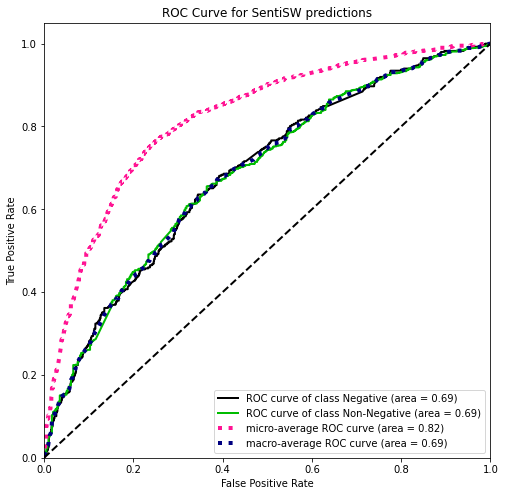

In [9]:
roc_name = 'visualizations/sentiSW_predictions_on_sentiCR_dataset.png'

converted_predictions = [convert_to_binary_prediction(sentiSW_predictions[i]['sentiment']) for i in range(len(sentiSW_predictions))]
y_true = ['Non-Negative' if x != -1 else 'Negative' for x in sentiCR_df['Annotation']]

ROC_curve(y_true, converted_predictions, roc_name)

# Metrics Report

In [10]:
load = True

test = sentiCR_df['text'].tolist()
name = 'pickled-predictions/sentiSW_label_predictions_on_sentiCR_dataset.pkl'

if(load):
    with open(name, 'rb') as f:
        sentiSW_predictions = pickle.load(f)
else:
    sentiSW_predictions = sentiSW_predict_labels(test, name)

sentiSW_predictions

[{'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentiment': 'Neutral', 'entity': None},
 {'sentimen

In [11]:
y_pred = ['Negative' if i['sentiment'] == 'Negative' else 'Non-Negative' for i in sentiSW_predictions]
y_pred

['Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 'Non-Negative',
 

In [12]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true, y_pred, average='macro')

(0.6282491503574359, 0.545788894514203, 0.5344876779160813, None)

In [13]:
precision_recall_fscore_support(y_true, y_pred, average='micro')

(0.7492182614133833, 0.7492182614133833, 0.7492182614133832, None)

In [14]:
precision_recall_fscore_support(y_true, y_pred, average='weighted')

(0.6992047355860158, 0.7492182614133833, 0.693261764977162, None)

# Create Contradictions sheet

In [15]:
sentiCR_df = sentiCR_df.reset_index()

sentiCR = ['Negative' if i == -1 else 'Non-Negative' for i in sentiCR_df['Annotation']]
aux = []
for i in range(len(sentiCR_df)):
    if ((sentiSW_predictions[i]['sentiment'] == 'Negative' and sentiCR[i] == 'Non-Negative') or ((sentiSW_predictions[i]['sentiment'] == 'Neutral' or sentiSW_predictions[i]['sentiment'] == 'Positive') and sentiCR[i] == 'Negative')):
        aux.append([sentiCR[i], sentiSW_predictions[i]['sentiment'], sentiCR_df['text'][i]])

diff = pd.DataFrame(aux, columns=['SentiCR Manual', 'SentiSW classification', 'Text'])

#import openpyxl

#diff.to_excel ('test1.xlsx', index = False, header=True)
diff

,SentiCR Manual,SentiSW classification,Text
0,Negative,Neutral,"""with the transition to ORM all we should care..."
1,Negative,Neutral,(minor) I suspect these CLASSERT() lines were ...
2,Negative,Neutral,(minor) Why out that in a comment instead of j...
3,Negative,Neutral,(style) I don't understand why this is in its ...
4,Negative,Neutral,"(style) why not format this normally, as is al..."
...,...,...,...
396,Negative,Neutral,You can open as many issue tickets as you like...
397,Negative,Neutral,You cannot design an API for logging. We shoul...
398,Negative,Neutral,You can't make changes directly to OOJS direct...
399,Negative,Neutral,you might be used to americanisms here. they ...


# Create SentiCR+ train set

In [ ]:
binary_sentiSW_df = sentiSW_df.filter(['text'], axis=1)
binary_sentiSW_df['Annotation'] = pd.Series(sentiSW, index=binary_sentiSW_df.index)

sentiSW_plus = pd.concat([binary_sentiSW_df, sentiCR_df], ignore_index=True)
sentiSW_plus